In [8]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

PROCESSED_DATA_PATH = "../data/processed/cleaned_data.pkl"

df = pd.read_pickle(PROCESSED_DATA_PATH)
print(f"Data shape: {df.shape}")
df.head(3)

Data shape: (16017, 19)


,brand,year,model,usedornew,transmission,engine,drivetype,fueltype,fuelconsumption,kilometres,cylindersinengine,bodytype,doors,seats,price,city,state,colour_ext,colour_int
0,Ssangyong,2022,Rexton,Demo,Automatic,2.2,Awd,Diesel,8.7,5595.0,4.0,Suv,4.0,7.0,51990.0,Caringbah,Nsw,Black,White
1,Mg,2022,Mg3,Used,Automatic,1.5,Front,Premium,6.7,16.0,4.0,Hatchback,5.0,5.0,19990.0,Brookvale,Nsw,Black,Black
2,Bmw,2022,430I,Used,Automatic,2.0,Rear,Premium,6.6,8472.0,4.0,Coupe,2.0,4.0,108988.0,Sylvania,Nsw,White,Grey


In [2]:
features_to_drop = ['price', 'model', 'city']

X = df.drop(columns=[col for col in features_to_drop if col in df.columns])
y = df['price']

y_log =  np.log1p(y)
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

print(f'Training: {X_train.shape}, Test: {X_test.shape}')

Training: (12813, 16), Test: (3204, 16)


In [3]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

print(f'Numeric features: {list(numeric_features)}')
print(f'Categorical features: {list(categorical_features)}')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_trasnformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_trasnformer, categorical_features)
    ]
)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
lr_model = LinearRegression()

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lr_model)
])

Numeric features: ['year', 'engine', 'fuelconsumption', 'kilometres', 'cylindersinengine', 'doors', 'seats']
Categorical features: ['brand', 'usedornew', 'transmission', 'drivetype', 'fueltype', 'bodytype', 'state', 'colour_ext', 'colour_int']


In [4]:
lr_pipeline.fit(X_train, y_train_log)


preds_log_lr = lr_pipeline.predict(X_test)
preds_real_lr = np.expm1(preds_log_lr)
y_test_real = np.expm1(y_test_log)

mae_lr = mean_absolute_error(y_test_real, preds_real_lr)
r2_lr = r2_score(y_test_real, preds_real_lr)

print(f"Linear Regression MAE: {mae_lr:.2f}")
print(f"Linear Regression R2:  {r2_lr:.4f}")

Linear Regression MAE: 6599.25
Linear Regression R2:  0.7649


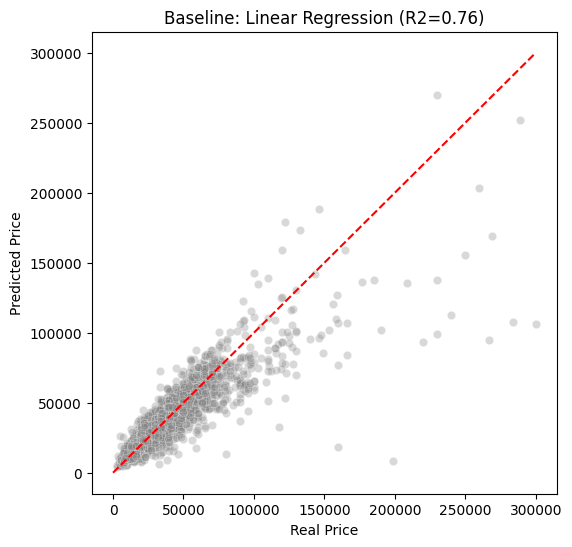

In [5]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_real, y=preds_real_lr, alpha=0.3, color='gray')
plt.plot([0, 300000], [0, 300000], 'r--')
plt.title(f"Baseline: Linear Regression (R2={r2_lr:.2f})")
plt.xlabel("Real Price")
plt.ylabel("Predicted Price")
plt.show()

In [6]:
param_distributions = {
    'model__n_estimators': [100, 200, 300, 500],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_leaf': [1, 2, 4],
    'model__min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_absolute_error'
)

random_search.fit(X_train, y_train_log)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best MAE: {random_search.best_score_}")

best_model = random_search.best_estimator_

preds_log_tuned = best_model.predict(X_test)

preds_real_tuned = np.expm1(preds_log_tuned)
y_test_real = np.expm1(y_test_log)

mae_tuned = mean_absolute_error(y_test_real, preds_real_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test_real, preds_real_tuned))
r2_tuned = r2_score(y_test_real, preds_real_tuned)

print(f"\n--- RESULTS ---")
print(f"MAE: {mae_tuned:.2f}")
print(f"RMSE: {rmse_tuned:.2f}")
print(f"R2 Score: {r2_tuned:.4f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': 20}
Best MAE: -0.15222064922418901

--- RESULTS ---
MAE: 5186.85
RMSE: 11583.32
R2 Score: 0.8217


In [9]:
filename = '../models/best_random_forest_model.joblib'
joblib.dump(best_model, filename)

['../models/best_random_forest_model.joblib']

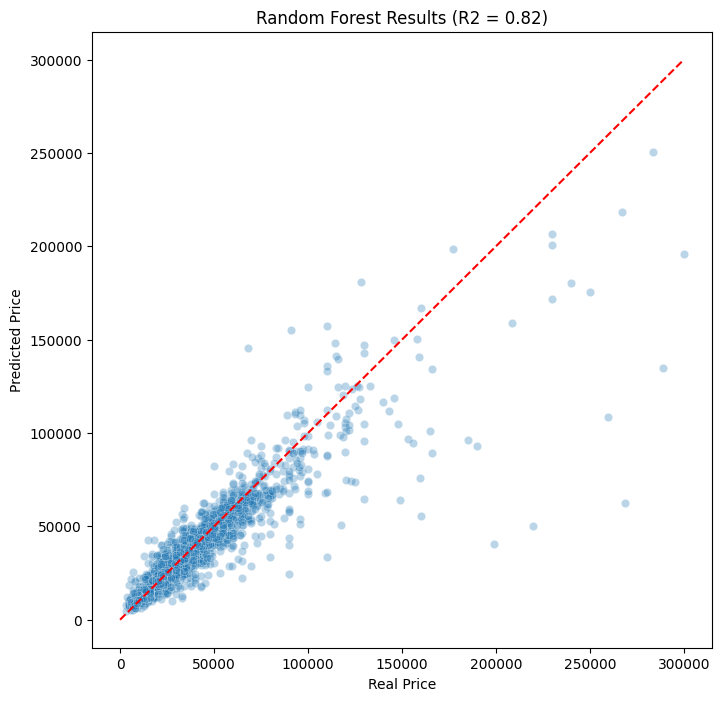

In [7]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test_real, y=preds_real_tuned, alpha=0.3)
plt.plot([0, 300000], [0, 300000], 'r--')
plt.xlabel("Real Price")
plt.ylabel("Predicted Price")
plt.title(f"Random Forest Results (R2 = {r2_tuned:.2f})")
plt.show()

In [8]:
import shap

final_pipeline = best_model

rf_model = final_pipeline.named_steps['model']
processor = final_pipeline.named_steps['preprocessor']

X_test_transformed = processor.transform(X_test)

feature_names = []
feature_names.extend(numeric_features)

cat_encoder = processor.named_transformers_['cat'].named_steps['onehot']
cat_names = cat_encoder.get_feature_names_out(categorical_features)
feature_names.extend(cat_names)

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_transformed[:100])

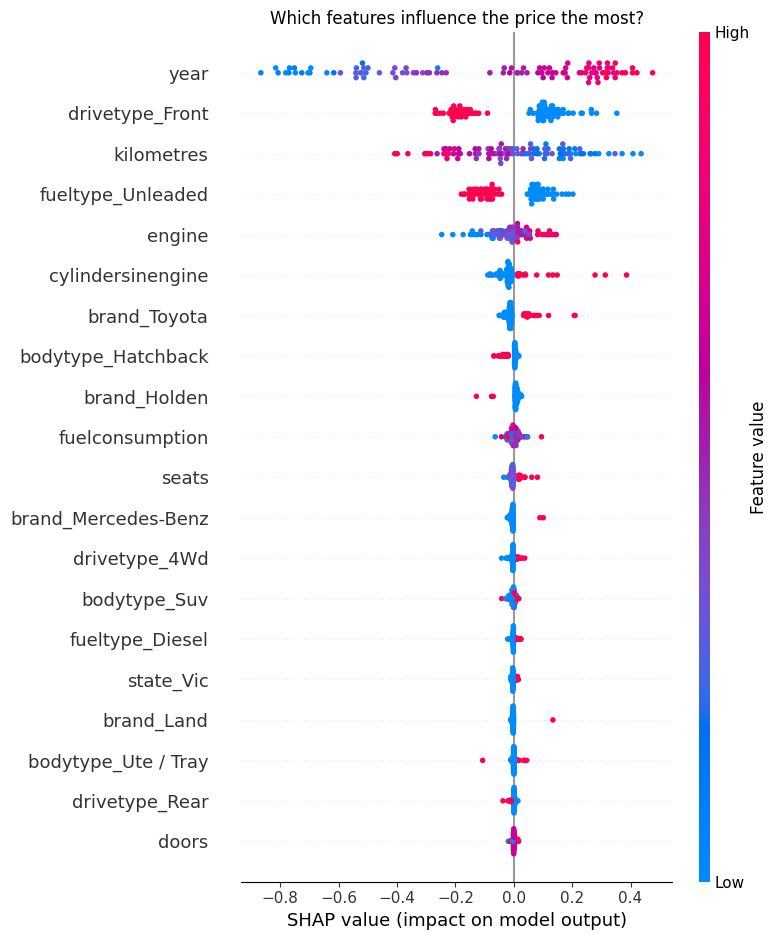

In [9]:
plt.figure(figsize=(10, 6))
plt.title("Which features influence the price the most?")
shap.summary_plot(shap_values, X_test_transformed[:100], feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()

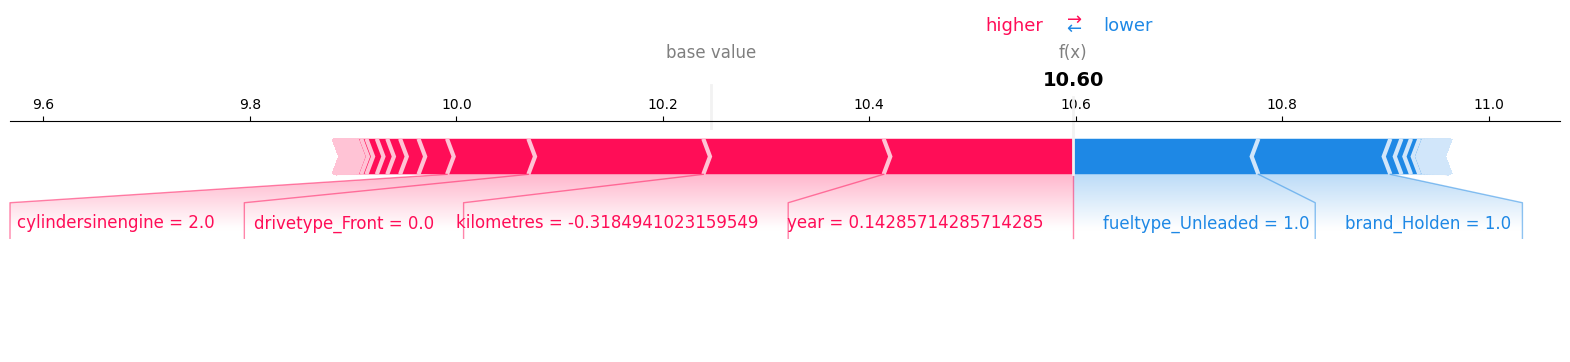

In [10]:
shap.force_plot(
    explainer.expected_value, 
    shap_values[0,:], 
    X_test_transformed[0,:], 
    feature_names=feature_names,
    matplotlib=True
)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [12]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_log.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_log.values, dtype=torch.float32).view(-1, 1)
print(f"Input Shape: {X_train_tensor.shape}")

Input Shape: torch.Size([12813, 440])


In [13]:
class CarPriceModel(nn.Module):
    def __init__(self, input_dim):
        super(CarPriceModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer2(x)
        x = self.relu(x)
        
        x = self.layer3(x)
        x = self.relu(x)
        
        x = self.output(x)
        return x

In [ ]:
input_dim = X_train_tensor.shape[1]
model_torch = CarPriceModel(input_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_torch.parameters(), lr=0.001)

epochs = 100
train_losses = []
test_losses = []

for epoch in range(epochs):

    model_torch.train()
    y_pred = model_torch(X_train_tensor)

    loss = criterion(y_pred, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

    model_torch.eval()
    with torch.no_grad():
        y_test_pred = model_torch(X_test_tensor)
        test_loss = criterion(y_test_pred, y_test_tensor)

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

model_torch.eval()
with torch.no_grad():
    preds_log_torch = model_torch(X_test_tensor).numpy()

preds_real_torch = np.expm1(preds_log_torch).flatten()

mae_torch = mean_absolute_error(y_test_real, preds_real_torch)
r2_torch = r2_score(y_test_real, preds_real_torch)

print(f"\n--- PyTorch Results ---")
print(f"MAE: {mae_torch:.2f}")
print(f"R2 Score: {r2_torch:.4f}")

Epoch [10/100], Training Loss: 102.0524, Test Loss: 101.6980
Epoch [20/100], Training Loss: 96.5628, Test Loss: 95.3475
Epoch [30/100], Training Loss: 75.4436, Test Loss: 71.7852
Epoch [40/100], Training Loss: 27.7030, Test Loss: 22.3559
Epoch [50/100], Training Loss: 7.5489, Test Loss: 8.1481
Epoch [60/100], Training Loss: 1.2820, Test Loss: 0.8296
Epoch [70/100], Training Loss: 1.6635, Test Loss: 1.3002
Epoch [80/100], Training Loss: 0.7072, Test Loss: 0.4439
Epoch [90/100], Training Loss: 0.5258, Test Loss: 0.2423
Epoch [100/100], Training Loss: 0.4899, Test Loss: 0.2439

--- PyTorch Results ---
MAE: 12350.70
R2 Score: 0.3496


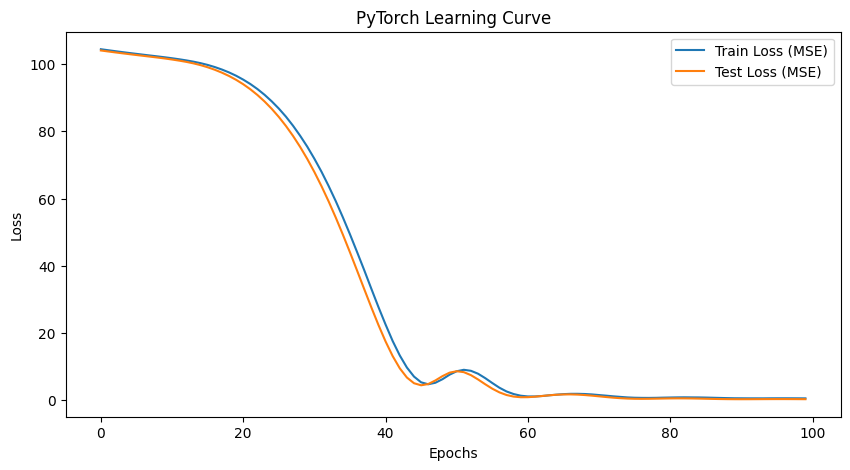

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss (MSE)')
plt.plot(test_losses, label='Test Loss (MSE)')
plt.title('PyTorch Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()